## Experiments on NTK model (verify proposition 1)

In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data as Data 
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import plotly.graph_objects as go
import random
import copy
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

def seed(seed=1029):
    random.seed(seed)
    np.random.seed(seed)
seed(1024)

K_CLAS = 3                          # Number of classes in the toy dataset
N_Data = int(640)                   # Number of samples in the dataset
TVT_SPLIT = [0.1, 0.1, 0.8]       # Split ratio between of train/valid/test dataset
N_Train = int(N_Data*TVT_SPLIT[0])  # Number of training samples
N_Valid = int(N_Data*TVT_SPLIT[1])  # Number of validation samples
N_Test = int(N_Data*TVT_SPLIT[2])   # Number of test samples

BATCH_SIZE = 1                     # Training batch size
EPOCHS = 200                        # Number of training epochs
UPDATES = EPOCHS*int(N_Train/BATCH_SIZE)
LR = 1e-4                           # Initial learning rate
X_DIM = 2                          # Dimension of input signal x
NOISE = 0.25                           # Noisy level when generating the dataset

HID_SIZE=2000

MU_VEC = np.array([[1,1,-1],[1,-1,1]]).T
#MU_VEC = np.array([[-1,1,0],[0,0,np.sqrt(3)]]).T
#MU_VEC = np.random.randint(-1,2,size=(K_CLAS,X_DIM))      # mu_1,...,mu_K
MU_VEC_ALL = np.tile(MU_VEC,(N_Data,1,1))

# Generate Dataset

In [ ]:
def _y_to_oht(label):
  label_oht = torch.zeros(label.shape[0],K_CLAS).to(label.device)
  label_oht.scatter_(1,label,1)
  label_oht = label_oht.float()
  return label_oht

def L2_distance_q_p(q, p,dim=None):
  if dim==None:
    return  nn.PairwiseDistance(p=2.0, eps=1e-12, keepdim=False)(q,p).detach().mean()
  else:
    return  nn.PairwiseDistance(p=2.0, eps=1e-12, keepdim=True)(q,p).detach().mean(dim)

def sigmoid(x):
  return 1/(1+np.exp(-x))

def y_to_oht(label):
  label_oht = torch.zeros(label.shape[0],K_CLAS).to(label.device)
  label_oht.scatter_(1,label,1)
  label_oht = label_oht.float()
  return label_oht

def data_gen(x,y,p):
  '''
    Pack everything to a train_loader and a val_lodaer
  '''
  x, y, p = torch.tensor(x), torch.tensor(y), torch.tensor(p)
  indices = list(range(N_Data))
  train_indices, val_indices, test_indices = indices[:N_Train], indices[N_Train:N_Train+N_Valid], indices[N_Train+N_Valid:]
  idx_train = torch.tensor(np.arange(0,N_Train,1))
  idx_valid = torch.tensor(np.arange(0,N_Valid,1))
  idx_test = torch.tensor(np.arange(0,N_Test,1))

  train_dataset = Data.TensorDataset(x[train_indices],y[train_indices],p[train_indices],idx_train)
  train_loader = Data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last = True)

  valid_dataset = Data.TensorDataset(x[val_indices],y[val_indices],p[val_indices],idx_valid)
  valid_loader = Data.DataLoader(valid_dataset, batch_size=N_Valid, shuffle=True, drop_last = True)

  test_dataset = Data.TensorDataset(x[test_indices],y[test_indices],p[test_indices],idx_test)
  test_loader = Data.DataLoader(test_dataset, batch_size=N_Test, shuffle=True, drop_last = True) 

  return train_loader, valid_loader, test_loader


In [ ]:
# =========== Generate all x, y and p===============================
idx_true = np.array(list(range(N_Data)))
y_true = np.random.randint(0,K_CLAS,[N_Data,1]).astype(np.float32)
mu_true = np.zeros((N_Data, X_DIM))
for i in range(N_Data):
  mu_true[i,:] = MU_VEC[y_true[i].astype(np.int),:]
x_true = mu_true + np.random.randn(N_Data, X_DIM)*np.sqrt(NOISE)

logits = np.zeros((N_Data,K_CLAS))
for k in range(K_CLAS):
  logits[:,k] = np.linalg.norm(x_true - MU_VEC_ALL[:,k,:], axis=1)**2*(-0.5/NOISE)
logits = torch.from_numpy(logits)
p_true = F.softmax(logits, 1)

# =========== Calculate the hardness for each sample ==============
y_true_oht = _y_to_oht(torch.tensor(y_true).long())
hard_true = L2_distance_q_p(y_true_oht, p_true,dim=1)

p_true = np.array(p_true)
hard_true = np.array(hard_true)

In [ ]:
data_df = pd.DataFrame(np.array([idx_true, y_true[:,0],hard_true,p_true[:,0],p_true[:,1],p_true[:,2]]).T,
                       columns=['idx','y','hard','p0','p1','p2'])
data_df_sorted = data_df.sort_values('hard',ascending=False)

In [ ]:
train_loader, valid_loader, test_loader = data_gen(x_true,y_true,p_true)

In [ ]:
X_Train = torch.tensor(x_true[:N_Train,:]).float()
Y_Train = torch.tensor(y_true[:N_Train]).long()
P_Train = torch.tensor(p_true[:N_Train])
IDX_Train = np.arange(0,N_Train,1)

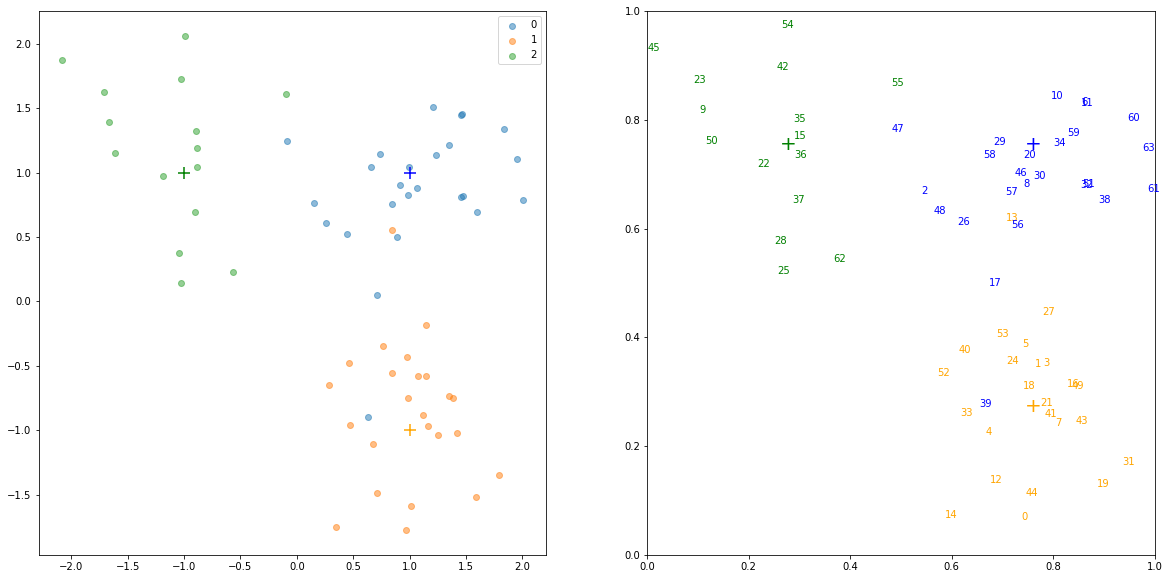

In [ ]:
#X_embedded = TSNE(n_components=2, perplexity=20).fit_transform(X_Train)
COLOR_TABLE = ['blue','orange','green']
figure, ax = plt.subplots(1,2,figsize=(20,10))
X_embedded = X_Train
for k in range(K_CLAS):
  ax[0].scatter(X_embedded[Y_Train.squeeze()==k,0],X_embedded[Y_Train.squeeze()==k,1],label=str(k),alpha=0.5)
  ax[0].scatter(MU_VEC[k,0],MU_VEC[k,1],s=150,marker='+',color=COLOR_TABLE[k])
ax[0].legend()

X_embedded_normed = X_embedded/(X_embedded.max()-X_embedded.min())
offset =  X_embedded_normed.min()
X_embedded_normed -= offset
MU_VEC_normed = MU_VEC/(X_embedded.max()-X_embedded.min())
MU_VEC_normed -= offset


for i in range(N_Train):
  tmp_x, tmp_y = X_embedded_normed[i,0],X_embedded_normed[i,1]
  tmp_clas = Y_Train[i]
  ax[1].text(tmp_x,tmp_y*0.98-0.01,str(i),fontsize=10,color=COLOR_TABLE[tmp_clas])
  if i==0:
    ax[1].text(MU_VEC_normed[0,0],MU_VEC_normed[0,1],'+',fontsize=20,color='blue')
    ax[1].text(MU_VEC_normed[1,0],MU_VEC_normed[1,1],'+',fontsize=20,color='orange')
    ax[1].text(MU_VEC_normed[2,0],MU_VEC_normed[2,1],'+',fontsize=20,color='green')

In [ ]:
data_df_sorted[data_df_sorted['idx']<N_Train][:]

,idx,y,hard,p0,p1,p2
39,39.0,0.0,1.413098e+00,7.862946e-04,9.992086e-01,5.066066e-06
13,13.0,1.0,1.396502e+00,9.869072e-01,1.195671e-02,1.136043e-03
47,47.0,0.0,9.495324e-01,3.285716e-01,1.525548e-05,6.714132e-01
17,17.0,0.0,5.752211e-01,5.922393e-01,4.057171e-01,2.043681e-03
55,55.0,2.0,4.472710e-01,3.162679e-01,8.139428e-07,6.837313e-01
...,...,...,...,...,...,...
9,9.0,2.0,2.342169e-06,1.656151e-06,2.414748e-11,9.999983e-01
23,23.0,2.0,1.613914e-06,1.141208e-06,2.548347e-12,9.999989e-01
14,14.0,1.0,1.173675e-06,8.042280e-07,9.999991e-01,4.918418e-08
0,0.0,1.0,9.645266e-07,6.818763e-07,9.999993e-01,2.939679e-10


## Function to draw learning path

In [ ]:
# ============ Necessary functions ==========
def p_to_xy(p,corners):
  # ==== p must have shape (x,3) =====
  x = p[:,0]*corners[0,0]+p[:,1]*corners[1,0]+p[:,2]*corners[2,0]
  y = p[:,0]*corners[0,1]+p[:,1]*corners[1,1]+p[:,2]*corners[2,1]
  return torch.stack((x.unsqueeze(1),y.unsqueeze(1)),dim=1).squeeze()

def p_to_xy_path(p,corners):
  # ==== p must have shape (id,x,3) =====
  x = p[:,:,0]*corners[0,0]+p[:,:,1]*corners[1,0]+p[:,:,2]*corners[2,0]
  y = p[:,:,0]*corners[0,1]+p[:,:,1]*corners[1,1]+p[:,:,2]*corners[2,1]
  return torch.stack((x.unsqueeze(1),y.unsqueeze(1)),dim=-1).squeeze()

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
def smooth_path(origin_path, alpha=0.9):
    for i in range(origin_path.shape[1]):
        if i==0:
            smooth_path = origin_path[:,0,:].unsqueeze(1)
            previous = smooth_path
        else:
            tmp = origin_path[:,i,:].unsqueeze(1)*(1-alpha) + previous*alpha
            smooth_path = torch.cat((smooth_path,tmp),dim=1)
            previous = tmp
    return smooth_path

def draw_path_coarse(path_id, smooth_level=0.9,highlight_ep=50, start_end=[0,UPDATES], 
                       NTK_or_base='NTK',ax=None,legend=True):
    '''
        Only works for train path and test path with correct predictions
    '''
    if ax is None:
        figure, ax = plt.subplots(1,1,figsize=(5,5))
    if NTK_or_base=='NTK':
      origin_path = NTK_path_train[path_id,:,:]
    elif NTK_or_base =='base':
      origin_path = base_path_train[path_id,:,:]
    y_star = p_to_xy_path(y_to_oht(torch.tensor(Y_Train[path_id]).unsqueeze(0).long()).unsqueeze(0),corners)
    p_star = p_to_xy_path(P_Train[path_id].unsqueeze(0).unsqueeze(0),corners)
    start_ep, end_ep = start_end[0], start_end[1]
    merged_path = np.zeros((origin_path.shape[0],3))

    merged_path[:,0] = origin_path[:,0]
    merged_path[:,1] = origin_path[:,1]
    merged_path[:,2] = np.ones(origin_path.shape[0])-origin_path[:,0]-origin_path[:,1]
    merged_path = torch.tensor(merged_path).unsqueeze(0)

    merged_path_smth = smooth_path(merged_path,smooth_level)
    path_to_draw = p_to_xy_path(merged_path,corners)
    path_to_draw_smth = p_to_xy_path(merged_path_smth,corners)

    highlight_idx = highlight_ep
    colors = range(end_ep-start_ep)
    ax.triplot(triangle)
    ax.axis('off')
    ax.axis('equal')

    ax.scatter(path_to_draw[start_ep:end_ep,0],path_to_draw[start_ep:end_ep,1],c=colors,cmap=plt.cm.Blues, edgecolors='none', s=40,alpha=0.8)
    ax.scatter(path_to_draw[end_ep:,0],path_to_draw[end_ep:,1],color='midnightblue', edgecolors='none', s=40,alpha=0.4)
    ax.scatter(path_to_draw[0,0],path_to_draw[0,1], color='blue',label='Origin Path',s=60,alpha=0.5)
    ax.scatter(y_star[0],y_star[1],color='red',label='OHT Label',s=150,alpha=0.8,marker='X')
    ax.scatter(p_star[0],p_star[1],color='grey',label='p* Label',s=150,alpha=0.8,marker='X')
    ax.scatter(path_to_draw[0,0],path_to_draw[0,1], color='green',label='Start',s=100,alpha=0.8,marker='D')
    ax.scatter(path_to_draw_smth[highlight_idx,0],path_to_draw_smth[highlight_idx,1], color='red',label='Early Stopped',s=300,alpha=0.8,marker='+')
    if smooth_level!=0:
      ax.scatter(path_to_draw[0,0],path_to_draw[0,1], color='red',label='Smoothed Path',s=60,alpha=0.5)
      ax.scatter(path_to_draw_smth[start_ep:end_ep,0],path_to_draw_smth[start_ep:end_ep,1],c=colors,cmap=plt.cm.Reds, edgecolors='none', s=40,alpha=0.8)
      ax.scatter(path_to_draw_smth[end_ep:,0],path_to_draw_smth[end_ep:,1],color='darkred', edgecolors='none', s=40,alpha=0.2)
    if legend:
      ax.legend() 

# Get the NTK from the initialized model

In [ ]:
class NN(nn.Module):
  def __init__(self, in_dim=X_DIM, hid_size=HID_SIZE):
    super(NN, self).__init__()
    self.in_dim = in_dim
    self.hid_size = hid_size    
    self.fc1 = nn.Linear(self.in_dim, self.hid_size)
    self.fc2 = nn.Linear(self.hid_size, K_CLAS)
    self.act = nn.ReLU(True)

  def forward(self, x):
    h1 = self.act(self.fc1(x))
    out = self.fc2(h1)
    return out

def _weight_init(m):
  nn.init.normal_(m.fc1.weight,0,1)
  nn.init.normal_(m.fc1.bias,0,1)
  nn.init.normal_(m.fc2.weight,0,1/HID_SIZE)
  nn.init.normal_(m.fc2.bias,0,1/HID_SIZE)    

# ================== Copy and run these when start a new training
model_NN = NN()       # Model for NTK
_weight_init(model_NN)
p_vec = nn.utils.parameters_to_vector(model_NN.parameters())
p_size = p_vec.shape[0]
n_size = X_Train.shape[0]
model_baseline = copy.deepcopy(model_NN)      # Model for NN SGD training
optimizer = optim.SGD(model_baseline.parameters(),lr=LR)

out = model_NN(X_Train)
ALL_Z_grad_W = torch.tensor([],requires_grad=False)
for idx_xi in range(n_size):
  Z_grad_W = torch.tensor([], requires_grad=False)
  for i in range(K_CLAS):
    model_NN.zero_grad()
    out[idx_xi,i].backward(retain_graph=True)
    zi_grad_W = torch.tensor([], requires_grad=False)
    for p in model_NN.parameters():
      zi_grad_W = torch.cat((zi_grad_W, p.grad.reshape(-1)))
    Z_grad_W = torch.cat((Z_grad_W, zi_grad_W.unsqueeze(-1)),1)
  ALL_Z_grad_W = torch.cat((ALL_Z_grad_W, Z_grad_W.unsqueeze(0)),0)


## Analyze matrix $K^0(x_o,x_u)$

In [ ]:
idx_list = list(data_df_sorted[data_df_sorted['idx']<N_Train][:]['idx'])
hard_list = list(data_df_sorted[data_df_sorted['idx']<N_Train][:]['hard'])

In [ ]:
# ----- Calculate Z given W -------
W0 = nn.utils.parameters_to_vector(model_NN.parameters()).unsqueeze(1)
def NTK_get_Z(W,x_idx):
  ALL_Z_W0 = ALL_Z_grad_W.transpose(1,2)[x_idx]
  ALL_f_w0 = out.unsqueeze(2)[x_idx]
  ALL_Z = torch.matmul(ALL_Z_W0,W) + ALL_f_w0 - torch.matmul(ALL_Z_W0,W0)
  return ALL_Z, ALL_Z_W0

NTK = torch.zeros((n_size,n_size,K_CLAS, K_CLAS))   # NTK is just a big matrix of size N*N, each element is a K*K matrix, which is (grd_z/w)^T(grd_z/w)
NTK_trace = torch.zeros((n_size,n_size))
NTK_Fnorm = torch.zeros((n_size,n_size))
for i in range(n_size):
  for j in range(n_size):
    xi_Z_grad_W = ALL_Z_grad_W[i,:,:]
    xj_Z_grad_W = ALL_Z_grad_W[j,:,:]
    NTK[i,j,:,:] = torch.matmul(xi_Z_grad_W.t(),xj_Z_grad_W)

for i in range(n_size):
  for j in range(n_size):
    NTK_trace[i,j] = torch.trace(NTK[i,j,:,:])
    NTK_Fnorm[i,j] = torch.norm(NTK[i,j,:,:])

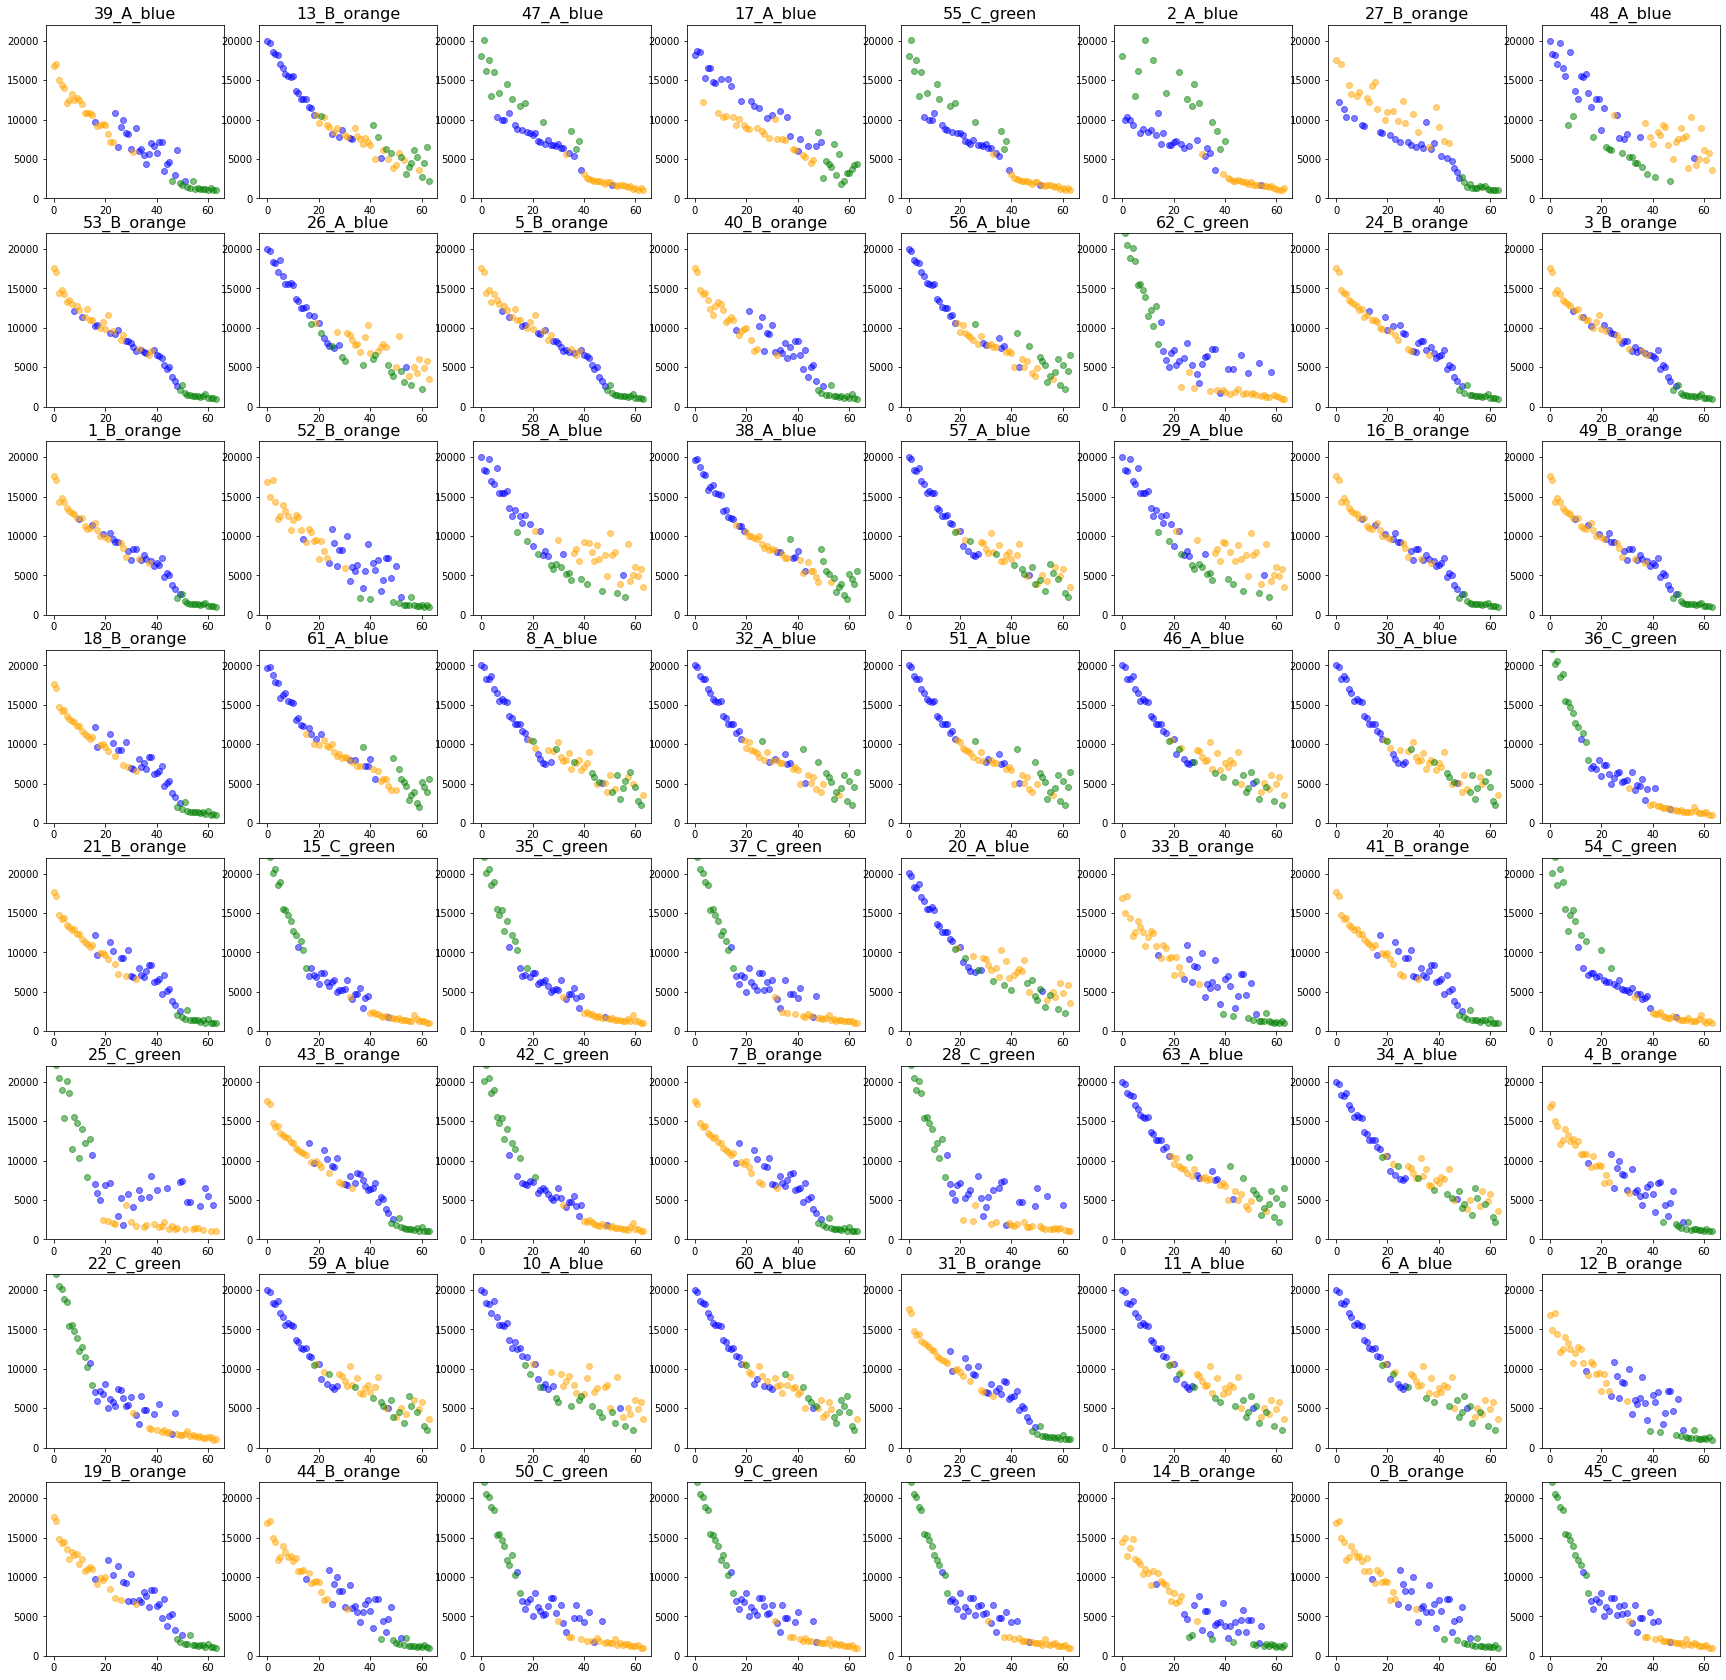

In [ ]:
class_label = ['A','B','C']
color_name_label = ['blue','orange','green']
figure, ax = plt.subplots(8,8,figsize=(30,30))
for c in range(8):
  for r in range(8):
    obs_idx = int(idx_list[c*8+r])
    obs_clas = Y_Train[obs_idx]
    dist_list = torch.zeros((n_size,))
    x_obs = X_Train[obs_idx]
    for i in range(n_size):
      x_i = X_Train[i]
      #dist_list[i] = torch.norm(x_obs-x_i)
      #dist_list[i] = torch.nn.functional.cosine_similarity(x_obs.unsqueeze(0),x_i.unsqueeze(0))
      dist_list[i] = torch.mm(x_obs.unsqueeze(0),x_i.unsqueeze(1))
    permut_mask = (-dist_list).argsort()
    Y0_mask = (Y_Train[permut_mask]==0).squeeze()
    Y1_mask = (Y_Train[permut_mask]==1).squeeze()
    Y2_mask = (Y_Train[permut_mask]==2).squeeze()
    Y0_x = np.arange(0,64,1)[Y0_mask]
    Y1_x = np.arange(0,64,1)[Y1_mask]
    Y2_x = np.arange(0,64,1)[Y2_mask]
    NTK_trace_perm = torch.zeros((n_size,n_size))
    NTK_Fnorm_perm = torch.zeros((n_size,n_size))
    for i in range(n_size):
      for j in range(n_size):
        ip, jp = permut_mask[i], permut_mask[j]
        NTK_trace_perm[i,j] = NTK_trace[ip,jp]
        NTK_Fnorm_perm[i,j] = NTK_Fnorm[ip,jp]
    ax[c][r].scatter(Y0_x,NTK_trace_perm[0][Y0_mask],color='blue',alpha=0.5)
    ax[c][r].scatter(Y1_x,NTK_trace_perm[0][Y1_mask],color='orange',alpha=0.5)
    ax[c][r].scatter(Y2_x,NTK_trace_perm[0][Y2_mask],color='green',alpha=0.5)
    ax[c][r].set_ylim(-1,22000)
    ax[c][r].set_title(str(obs_idx)+'_'+class_label[obs_clas]+'_'+color_name_label[obs_clas],fontsize=16)
    #ax[c][r].set_ylim(200,11000)

## Train the NTK model, track the behavior of matrix $A(x_o)$

We will first check whether matrix $A(x_o)$ is PSD during the training.

In [ ]:
def get_A_PSD(q):
  q = q.squeeze()
  PSD_TF = False
  A = torch.tensor([[q[0]*(1-q[0]),   -q[0]*q[1],     -q[0]*q[2]],
                [-q[1]*q[0],      q[1]*(1-q[1]),  -q[1]*q[2]],
                [-q[2]*q[0],      -q[2]*q[1],     q[2]*(1-q[2])]])
  u,s,v = torch.svd(A)
  A_trace = s.sum()
  if (s>=0).sum()==3:
    PSD_TF = True
  return A, PSD_TF, A_trace

In [ ]:
# ================== Copy and run these when start a new training
model_NN = NN()       # Model for NTK
_weight_init(model_NN)
p_vec = nn.utils.parameters_to_vector(model_NN.parameters())
p_size = p_vec.shape[0]
n_size = X_Train.shape[0]
model_baseline = copy.deepcopy(model_NN)      # Model for NN SGD training
optimizer = optim.SGD(model_baseline.parameters(),lr=LR)

out = model_NN(X_Train)
ALL_Z_grad_W = torch.tensor([],requires_grad=False)
for idx_xi in range(n_size):
  Z_grad_W = torch.tensor([], requires_grad=False)
  for i in range(K_CLAS):
    model_NN.zero_grad()
    out[idx_xi,i].backward(retain_graph=True)
    zi_grad_W = torch.tensor([], requires_grad=False)
    for p in model_NN.parameters():
      zi_grad_W = torch.cat((zi_grad_W, p.grad.reshape(-1)))
    Z_grad_W = torch.cat((Z_grad_W, zi_grad_W.unsqueeze(-1)),1)
  ALL_Z_grad_W = torch.cat((ALL_Z_grad_W, Z_grad_W.unsqueeze(0)),0)

In [ ]:
loss_train_table = []
acc_train_table = []
base_loss_train_table = []
base_acc_train_table = []
PSD_LIST = []
A_LIST = []
A_trace_record = torch.zeros((N_Train,EPOCHS))
base_path_train = np.zeros((N_Train,UPDATES,K_CLAS))
NTK_path_train = np.zeros((N_Train,UPDATES,K_CLAS))
W_NTK = W0
path_idx = 0
for ep in range(EPOCHS):
  acc_train = 0
  base_acc_train = 0
  cnt = 0
  for x,y,p,idx in train_loader:
# ------ This can let us try LOOV ------
#    if idx==39:
#      continue
    base_z_train_all = model_baseline(X_Train)
    base_q_train_all = nn.Softmax(1)(base_z_train_all.detach())
    NTK_z_train_all, _ = NTK_get_Z(W_NTK, IDX_Train)
    NTK_q_train_all = nn.Softmax(1)(NTK_z_train_all.detach())
    base_path_train[:,path_idx,:] = base_q_train_all
    NTK_path_train[:,path_idx,:] = NTK_q_train_all.squeeze()
    path_idx += 1

    x_batch, y_batch, idx_batch = x.float(), y.long(), idx
    yoht_batch = y_to_oht(y_batch.long()).unsqueeze(-1)

    # ============== Base model training ==========
    #  --------- Base parameter update
    optimizer.zero_grad()
    z_base = model_baseline(x_batch)
    z_base = z_base.unsqueeze(-1)
    base_loss = nn.CrossEntropyLoss()(z_base, y_batch)
    base_loss.backward()
    optimizer.step()
    # ------------- Base evalutate
    base_loss_train_table.append(base_loss.item())
    base_acc_train += (z_base.argmax(1).eq(y_batch)).sum()

    # ============== NTK model training ==========
    #  -------- NTK parameter update
    z_batch, z_w0_batch = NTK_get_Z(W_NTK,idx_batch)
    q_batch = nn.Softmax(1)(z_batch)
    L_W = torch.matmul((q_batch-yoht_batch).transpose(1,2),z_w0_batch).mean(0).transpose(0,1)
    W_NTK = W_NTK - LR*L_W
    #  ------- NTK evaluate
    z_train, _ = NTK_get_Z(W_NTK,idx_batch)
    acc_train += (z_train.argmax(1).eq(y_batch)).sum()
    cnt += x.shape[0]
    loss_train = nn.CrossEntropyLoss()(z_train,y_batch).detach()
    loss_train_table.append(loss_train)
    #  ------- Get matrix A and whether it is PSD -----
    q_train = nn.Softmax(1)(z_train).detach()
    A, PSD_FLAG, A_trace = get_A_PSD(q_train)
    PSD_LIST.append(PSD_FLAG)
    A_LIST.append(A)
    A_trace_record[idx,ep] = A_trace
  # ----------- At the end of each epoch -----------
  acc_train_table.append(acc_train/cnt)
  base_acc_train_table.append(base_acc_train/cnt)
  if ep==0:
    W_NTK_1 = copy.deepcopy(W_NTK.detach())
  if ep==1:
    W_NTK_2 = copy.deepcopy(W_NTK.detach())
  if ep==2:
    W_NTK_3 = copy.deepcopy(W_NTK.detach())
  if ep==3:
    W_NTK_4 = copy.deepcopy(W_NTK.detach())
  if ep==10:
    W_NTK_10 = copy.deepcopy(W_NTK.detach())
  if ep==40:
    W_NTK_40 = copy.deepcopy(W_NTK.detach())
  if ep==150:
    W_NTK_Converge = copy.deepcopy(W_NTK.detach())

## Emperically check whether $A(x_o)$ is PSD. And observe how the $tr(A(x_o))$ change during training

In [ ]:
np.sum(PSD_LIST)/len(PSD_LIST)

1.0

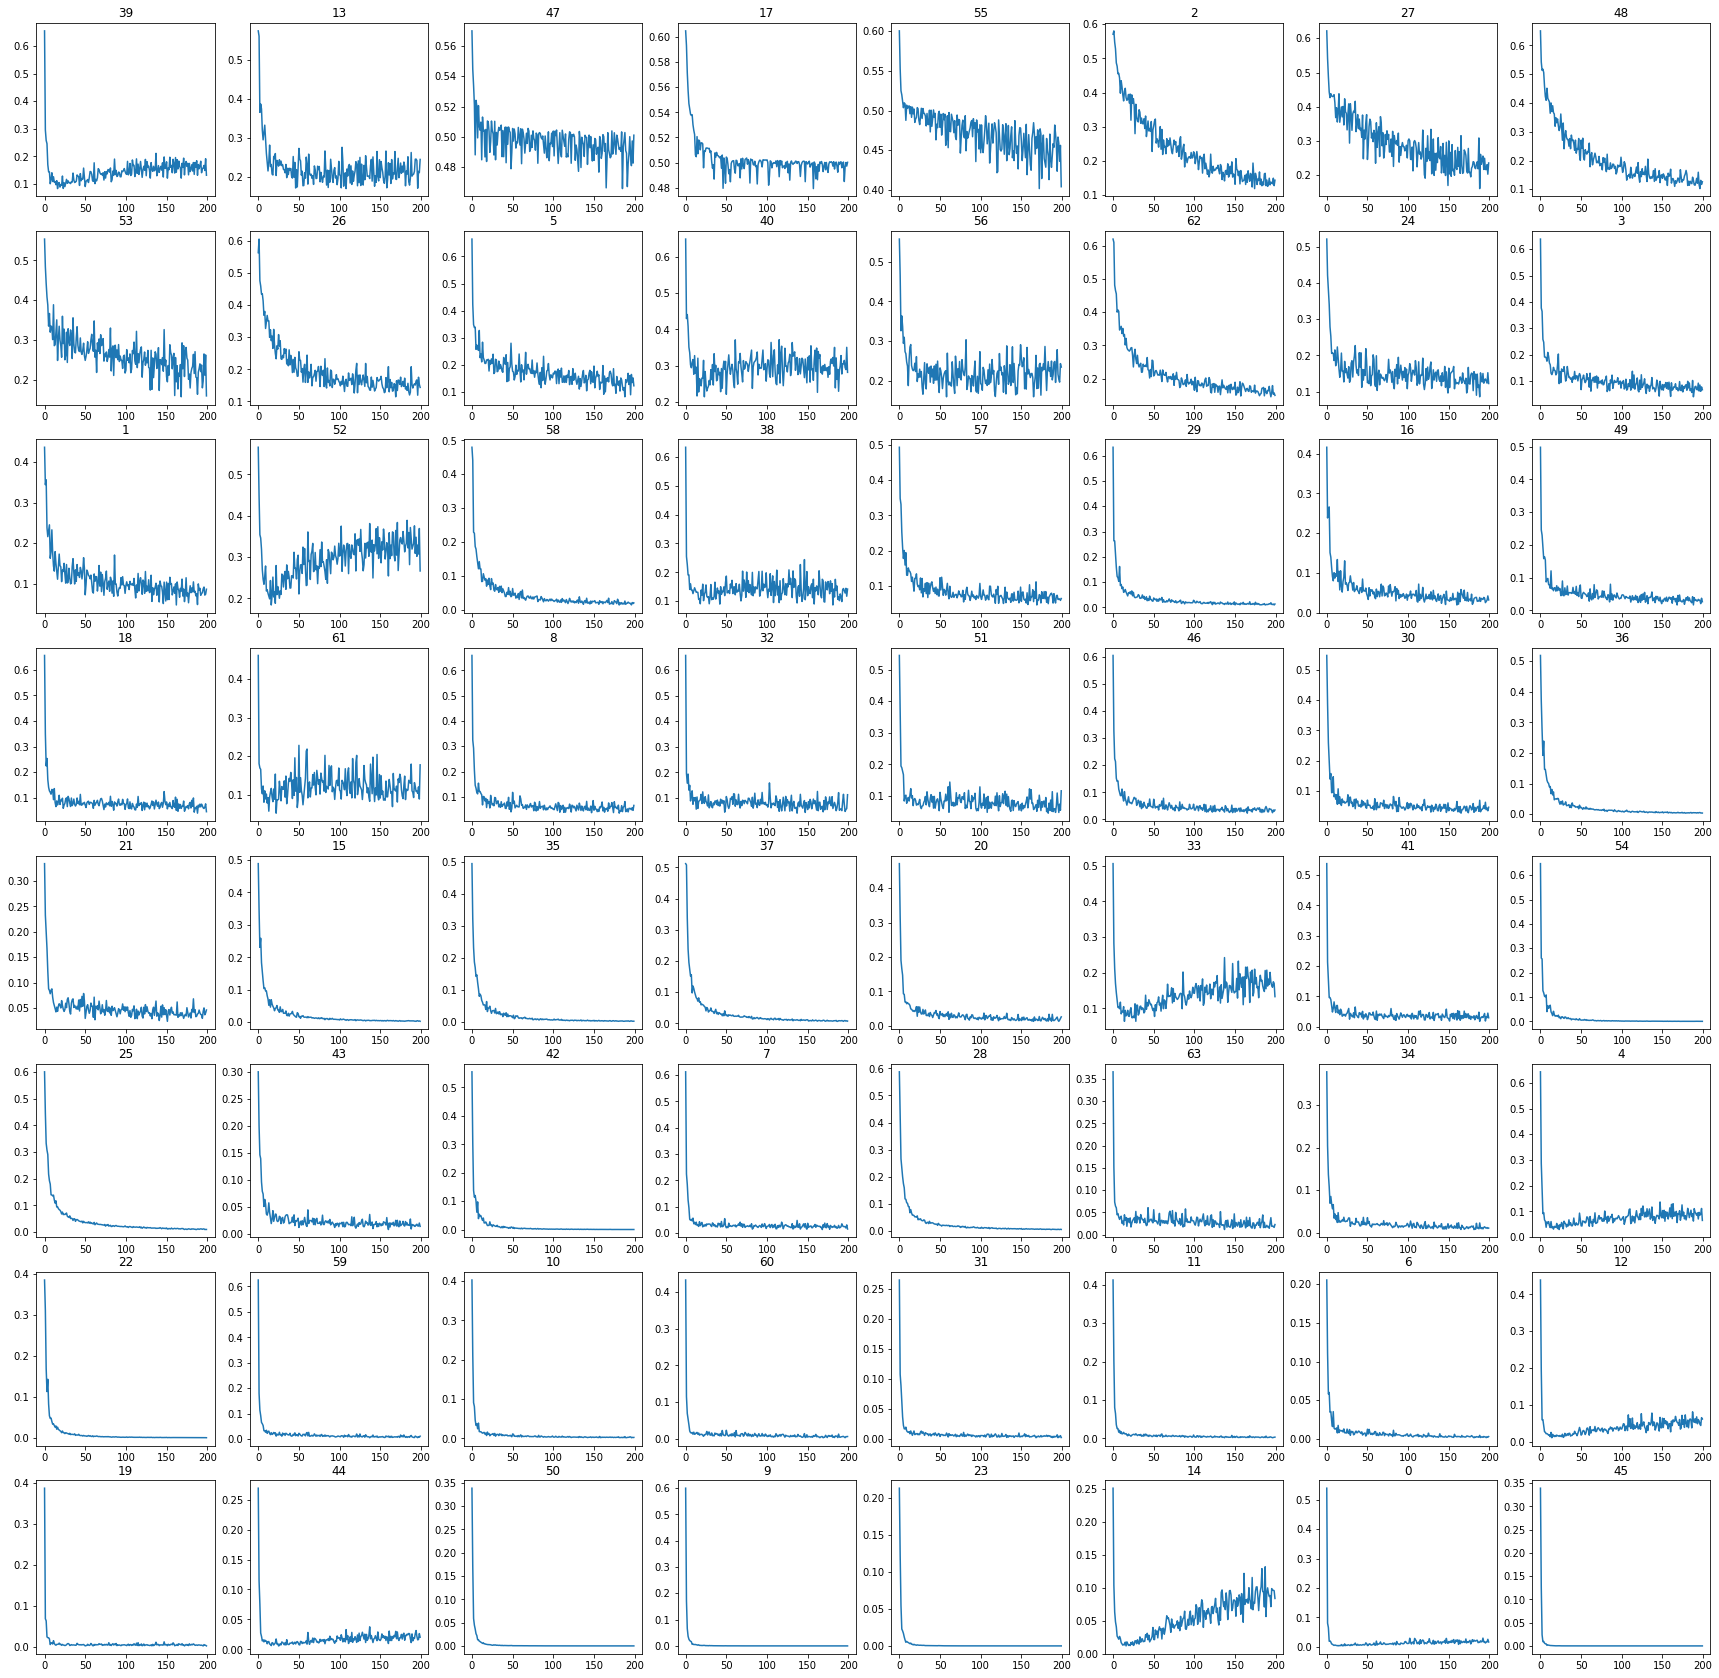

In [ ]:
figure, ax = plt.subplots(8,8,figsize=(30,30))
for c in range(8):
  for r in range(8):
    idx = int(idx_list[c*8+r])
    ax[c][r].plot(A_trace_record[idx,:])
    ax[c][r].set_title(str(idx))
    #ax[c][r].set_ylim(-0.05,0.7)

In [ ]:
A_trace_record.shape

torch.Size([64, 200])

In [ ]:
idx = int(idx_list[c*8+r])

In [ ]:
idx_list[0]

39.0

In [ ]:
A_LIST[-2]

tensor([[ 1.1796e-01, -1.1796e-01, -3.5867e-06],
        [-1.1796e-01,  1.1798e-01, -2.2664e-05],
        [-3.5867e-06, -2.2664e-05,  2.6251e-05]])

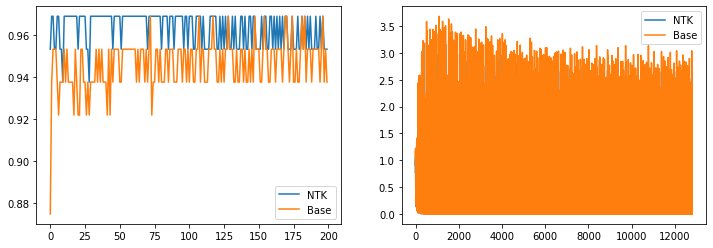

In [ ]:
figure, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(acc_train_table,label='NTK')
ax[0].plot(base_acc_train_table,label='Base')
ax[0].legend()

ax[1].plot(loss_train_table,label='NTK')
ax[1].plot(base_loss_train_table,label='Base')
ax[1].legend()

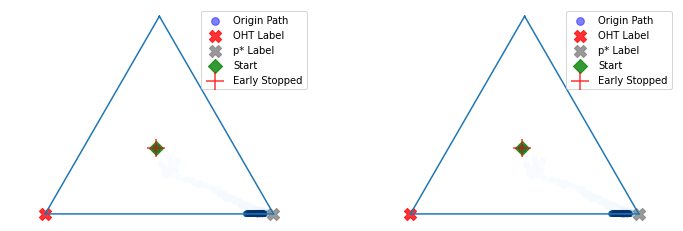

In [ ]:
# We can enable or unenable the update of 39th sample and compare 
# (with 39th, the path converge to left corner, without it, the path hangling around right corner.)
path_id = 39
SMOOTH = 0
figure_path, ax_path = plt.subplots(1,2,figsize=(12,4))
draw_path_coarse(path_id, smooth_level=SMOOTH,highlight_ep = 0, start_end=[0,UPDATES], NTK_or_base='NTK',ax=ax_path[0])
draw_path_coarse(path_id, smooth_level=SMOOTH,highlight_ep = 0, start_end=[0,UPDATES], NTK_or_base='base',ax=ax_path[1])

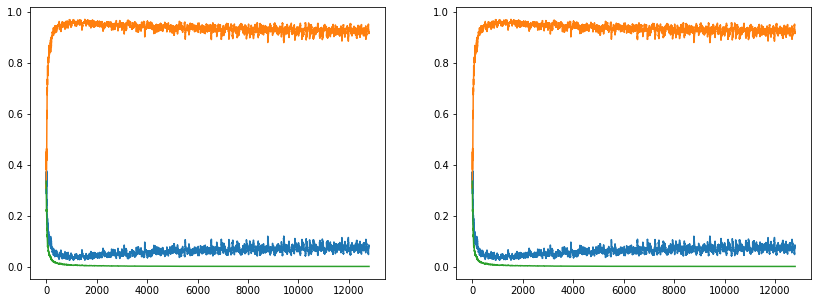

In [ ]:
figure, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(base_path_train[path_id,:,:])
ax[1].plot(NTK_path_train[path_id,:,:])

# Observe the detailed learning trajectory

## Step1: observe one sample

In [ ]:
W_NTK = W0
#W_NTK = W_NTK_Converge
id_obs = 39
x_ob, y_observe, p_observe = X_Train[id_obs], Y_Train[id_obs], P_Train[id_obs]
z_obs, z_w0_obs = NTK_get_Z(W_NTK,id_obs)
q_obs = nn.Softmax(0)(z_obs).detach()

id_upd = 0
x_upd, y_upd, p_upd = X_Train[id_upd], Y_Train[id_upd].unsqueeze(1), P_Train[id_upd]
y_oht_upd = y_to_oht(y_upd.long()).unsqueeze(-1)
z_upd, z_w0_upd = NTK_get_Z(W_NTK,id_upd)
q_upd = nn.Softmax(0)(z_upd).detach()

L_W = torch.matmul((q_upd-y_oht_upd).transpose(1,2),z_w0_upd).mean(0).transpose(0,1)
W_NTK = W_NTK - LR*L_W*2

z_obs2, _ = NTK_get_Z(W_NTK,id_obs)
q_obs2 = nn.Softmax(0)(z_obs2).detach()

z_upd2, _ = NTK_get_Z(W_NTK,id_upd)
q_upd2 = nn.Softmax(0)(z_upd2).detach()

In [ ]:
y_star_obs = p_to_xy_path(y_to_oht(torch.tensor(Y_Train[id_obs]).unsqueeze(0).long()).unsqueeze(0),corners)
p_star_obs = p_to_xy_path(P_Train[id_obs].unsqueeze(0).unsqueeze(0),corners)
q_orig_obs = p_to_xy_path(q_obs.t().unsqueeze(0),corners)
q_orig_obs2 = p_to_xy_path(q_obs2.t().unsqueeze(0),corners)

y_star_upd = p_to_xy_path(y_to_oht(torch.tensor(Y_Train[id_upd]).unsqueeze(0).long()).unsqueeze(0),corners)
p_star_upd = p_to_xy_path(P_Train[id_upd].unsqueeze(0).unsqueeze(0),corners)
q_orig_upd = p_to_xy_path(q_upd.t().unsqueeze(0),corners)
q_orig_upd2 = p_to_xy_path(q_upd2.t().unsqueeze(0),corners)

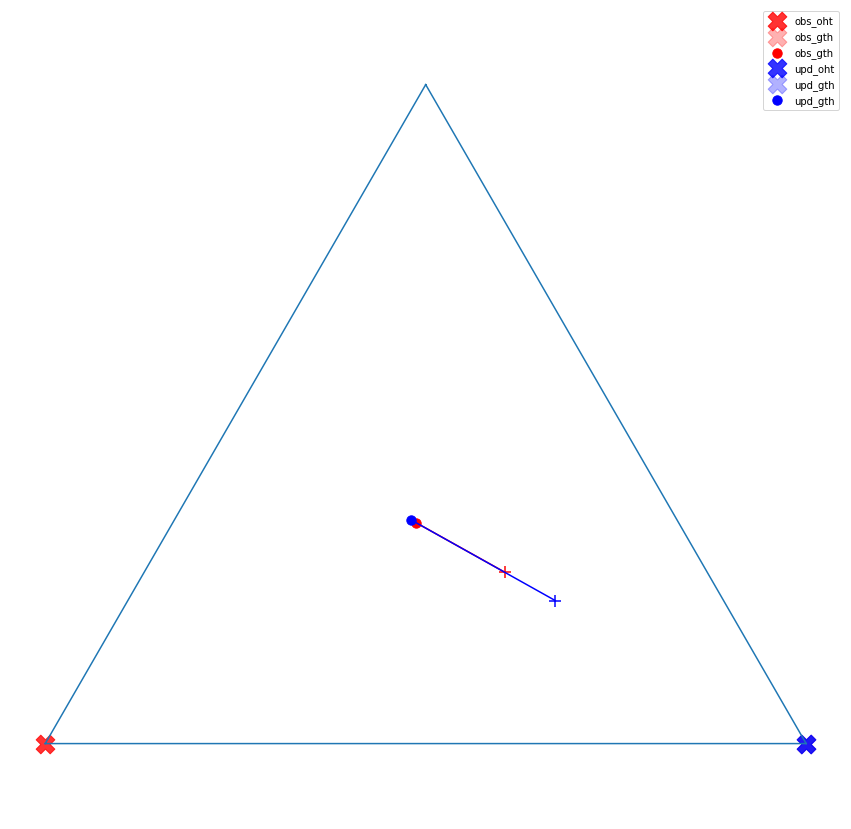

In [ ]:
figure, ax = plt.subplots(1,1,figsize=(15,15))
ax.triplot(triangle)
ax.axis('off')
ax.axis('equal')

ax.scatter(y_star_obs[0],y_star_obs[1],color='red',label='obs_oht',s=350,alpha=0.8,marker='X')
ax.scatter(p_star_obs[0],p_star_obs[1],color='red',label='obs_gth',s=350,alpha=0.3,marker='X')
ax.scatter(q_orig_obs[0],q_orig_obs[1],color='red',label='obs_gth',s=350,alpha=1,marker='.')
ax.scatter(q_orig_obs2[0],q_orig_obs2[1],color='red',s=150,alpha=1,marker='+')
ax.plot([q_orig_obs[0],q_orig_obs2[0]],[q_orig_obs[1],q_orig_obs2[1]],color='red')


ax.scatter(y_star_upd[0],y_star_upd[1],color='blue',label='upd_oht',s=350,alpha=0.8,marker='X')
ax.scatter(p_star_upd[0],p_star_upd[1],color='blue',label='upd_gth',s=350,alpha=0.3,marker='X')
ax.scatter(q_orig_upd[0],q_orig_upd[1],color='blue',label='upd_gth',s=350,alpha=1,marker='.')
ax.scatter(q_orig_upd2[0],q_orig_upd2[1],color='blue',s=150,alpha=1,marker='+')
ax.plot([q_orig_upd[0],q_orig_upd2[0]],[q_orig_upd[1],q_orig_upd2[1]],color='blue')
ax.legend()

## Step2: observe the learning path of several steps

In [ ]:
W_NTK = W0
#W_NTK = W_NTK_1
#W_NTK = W_NTK_2
#W_NTK = W_NTK_3
#W_NTK = W_NTK_4
#W_NTK = W_NTK_10
#W_NTK = W_NTK_40
#W_NTK = W_NTK_Converge
id_obs = 39

q_obs_list = []
id_upd_list = np.arange(0,50,1)
q_upd_orig_list = []
q_upd_next_list = []

x_ob, y_observe, p_observe = X_Train[id_obs], Y_Train[id_obs], P_Train[id_obs]
z_obs, z_w0_obs = NTK_get_Z(W_NTK,id_obs)
q_obs = nn.Softmax(0)(z_obs).detach()

q_obs_list.append(q_obs)
for i in range(len(id_upd_list)):
  id_upd = id_upd_list[i]
  x_upd, y_upd, p_upd = X_Train[id_upd], Y_Train[id_upd].unsqueeze(1), P_Train[id_upd]
  y_oht_upd = y_to_oht(y_upd.long()).unsqueeze(-1)
  z_upd_orig, z_w0_upd = NTK_get_Z(W_NTK,id_upd)
  q_upd_orig = nn.Softmax(0)(z_upd_orig).detach()
  q_upd_orig_list.append(q_upd_orig)

  L_W = torch.matmul((q_upd_orig-y_oht_upd).transpose(1,2),z_w0_upd).mean(0).transpose(0,1)
  W_NTK = W_NTK - LR*L_W

  z_obs_next, _ = NTK_get_Z(W_NTK,id_obs)
  q_obs_next = nn.Softmax(0)(z_obs_next).detach()
  q_obs_list.append(q_obs_next)
  z_upd_next, _ = NTK_get_Z(W_NTK,id_upd)
  q_upd_next = nn.Softmax(0)(z_upd2).detach()
  q_upd_next_list.append(q_upd_next)

# ------- The oht and p* for observing sample -------
y_star_obs = p_to_xy_path(y_to_oht(torch.tensor(Y_Train[id_obs]).unsqueeze(0).long()).unsqueeze(0),corners)
p_star_obs = p_to_xy_path(P_Train[id_obs].unsqueeze(0).unsqueeze(0),corners)

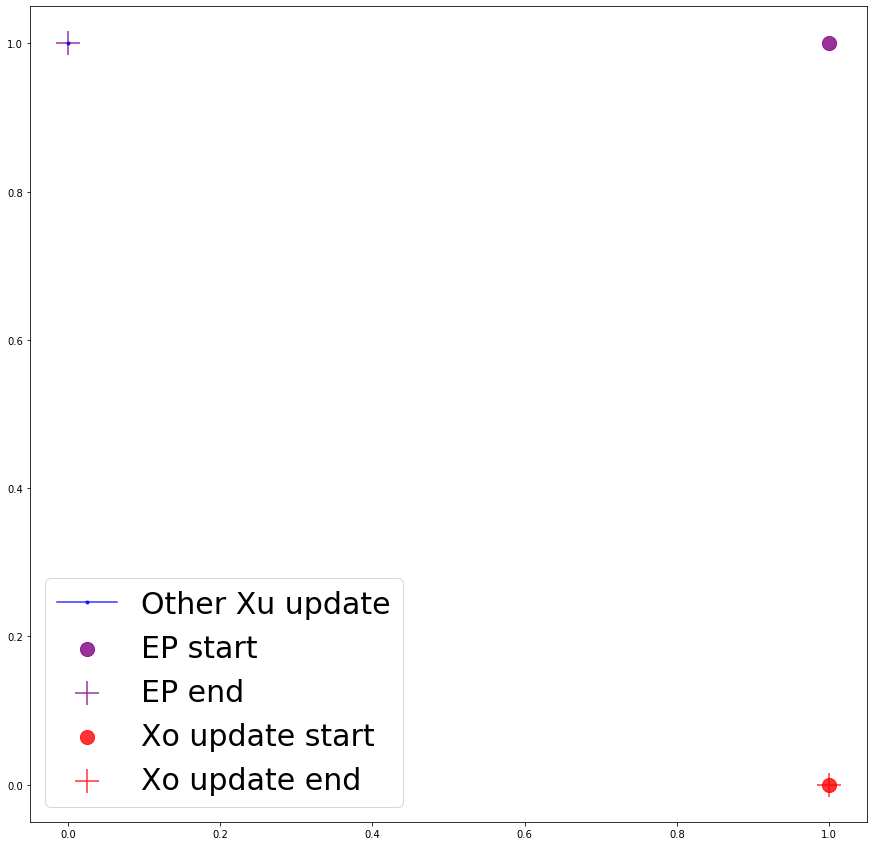

In [ ]:
# We only use this to generate legends, ignore the image...
figure, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(1,1,color='purple',s=800,alpha=0.8,marker='.',label='EP start')
ax.scatter(0,1,color='purple',s=600,alpha=0.8,marker='+',label='EP end')
ax.plot(0,1,color='blue',alpha=0.8,marker='.',label='Other Xu update')
ax.scatter(1,0,color='red',s=800,alpha=0.8,marker='.',label='Xo update start')
ax.scatter(1,0,color='red',s=600,alpha=0.8,marker='+',label='Xo update end')
ax.legend(fontsize=30)

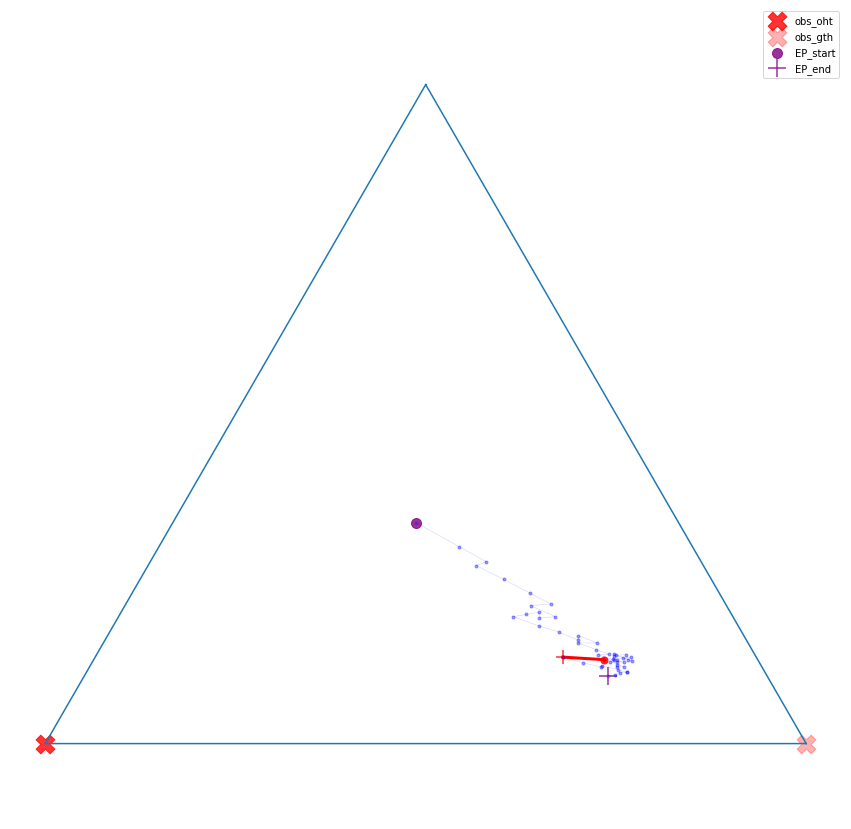

In [ ]:
figure, ax = plt.subplots(1,1,figsize=(15,15))
ax.triplot(triangle)
ax.axis('off')
ax.axis('equal')
# ========== Draw the observed path ============
ax.scatter(y_star_obs[0],y_star_obs[1],color='red',label='obs_oht',s=350,alpha=0.8,marker='X')
ax.scatter(p_star_obs[0],p_star_obs[1],color='red',label='obs_gth',s=350,alpha=0.3,marker='X')
for i in range(len(id_upd_list)-1):
  if id_upd_list[i]==id_obs:
    line_color = 'red'
    line_width = 3
    line_alpha = 1
  else:
    line_color = 'blue'
    line_width = 0.5
    line_alpha = 0.2
  star = p_to_xy_path(q_obs_list[i].t().unsqueeze(0),corners)
  next = p_to_xy_path(q_obs_list[i+1].t().unsqueeze(0),corners)
  #ax.scatter(star[0],star[1],color='red',s=100,alpha=0.8,marker='.')
  ax.plot([star[0],next[0]],[star[1],next[1]],color=line_color,marker='.',linewidth=line_width,alpha=line_alpha)
  if id_upd_list[i]==id_obs:
    ax.scatter(star[0],star[1],color='red',s=200,alpha=0.8,marker='.')
    ax.scatter(next[0],next[1],color='red',s=200,alpha=0.8,marker='+')
  if i==0:
    ax.scatter(star[0],star[1],color='purple',s=400,alpha=0.8,marker='.',label='EP_start')
  if i==48:
    ax.scatter(next[0],next[1],color='purple',s=300,alpha=0.8,marker='+',label='EP_end')
ax.legend()
plt.savefig('Project1/Figures/multi_steps_ep200.pdf')

## Step3: observe the gradient when batch_size=2
(can see the vector addition effect)

In [ ]:
amplify = 5
W_NTK = W0
#W_NTK = W_NTK_Converge
id_obs = 39
x_ob, y_observe, p_observe = X_Train[id_obs], Y_Train[id_obs], P_Train[id_obs]
z_obs, z_w0_obs = NTK_get_Z(W_NTK,id_obs)
q_obs = nn.Softmax(0)(z_obs).detach()


id_upd = [17,44]
# ------------------ If we update them seperately -------------
x_updA, y_updA, p_updA = X_Train[id_upd[0]], Y_Train[id_upd[0]].long().unsqueeze(1), P_Train[id_upd[0]]
y_oht_updA = y_to_oht(y_updA.long()).unsqueeze(-1)
z_updA, z_w0_updA = NTK_get_Z(W_NTK,id_upd[0])
q_updA = nn.Softmax(0)(z_updA)
L_WA = torch.matmul((q_updA-y_oht_updA).transpose(1,2),z_w0_updA).mean(0).transpose(0,1)
W_NTKA = W_NTK - LR*L_WA*amplify
z_upd2A, _ = NTK_get_Z(W_NTKA,id_upd[0])
q_upd2A = nn.Softmax(0)(z_upd2A).detach()

x_updB, y_updB, p_updB = X_Train[id_upd[1]], Y_Train[id_upd[1]].long().unsqueeze(1), P_Train[id_upd[1]]
y_oht_updB = y_to_oht(y_updB.long()).unsqueeze(-1)
z_updB, z_w0_updB = NTK_get_Z(W_NTK,id_upd[1])
q_updB = nn.Softmax(0)(z_updB)
L_WB = torch.matmul((q_updB-y_oht_updB).transpose(1,2),z_w0_updB).mean(0).transpose(0,1)
W_NTKB = W_NTK - LR*L_WB*amplify
z_upd2B, _ = NTK_get_Z(W_NTKB,id_upd[1])
q_upd2B = nn.Softmax(0)(z_upd2B).detach()

# --------------- Then update parameter as a batch, and see the observation signal --------------
x_upd, y_upd, p_upd = X_Train[id_upd], Y_Train[id_upd].long().unsqueeze(1), P_Train[id_upd]
y_oht_upd = y_to_oht(y_upd.squeeze(1)).unsqueeze(-1)
z_upd, z_w0_upd = NTK_get_Z(W_NTK,id_upd)
q_upd = nn.Softmax(1)(z_upd).detach()

L_W = torch.matmul((q_upd-y_oht_upd).transpose(1,2),z_w0_upd).mean(0).transpose(0,1)
W_NTK = W_NTK - LR*L_W*amplify

z_obs2, _ = NTK_get_Z(W_NTK,id_obs)
q_obs2 = nn.Softmax(0)(z_obs2).detach()


In [ ]:
y_star_obs = p_to_xy_path(y_to_oht(torch.tensor(Y_Train[id_obs]).unsqueeze(0).long()).unsqueeze(0),corners)
p_star_obs = p_to_xy_path(P_Train[id_obs].unsqueeze(0).unsqueeze(0),corners)
q_orig_obs = p_to_xy_path(q_obs.t().unsqueeze(0),corners)
q_orig_obs2 = p_to_xy_path(q_obs2.t().unsqueeze(0),corners)

y_star_updA = p_to_xy_path(y_to_oht(torch.tensor(Y_Train[id_upd[0]]).unsqueeze(0).long()).unsqueeze(0),corners)
p_star_updA = p_to_xy_path(P_Train[id_upd[0]].unsqueeze(0).unsqueeze(0),corners)
q_orig_updA = p_to_xy_path(q_upd[0].t().unsqueeze(0),corners)
q_orig_upd2A = p_to_xy_path(q_upd2A.t().unsqueeze(0),corners)

y_star_updB = p_to_xy_path(y_to_oht(torch.tensor(Y_Train[id_upd[1]]).unsqueeze(0).long()).unsqueeze(0),corners)
p_star_updB = p_to_xy_path(P_Train[id_upd[1]].unsqueeze(0).unsqueeze(0),corners)
q_orig_updB = p_to_xy_path(q_upd[1].t().unsqueeze(0),corners)
q_orig_upd2B = p_to_xy_path(q_upd2B.t().unsqueeze(0),corners)

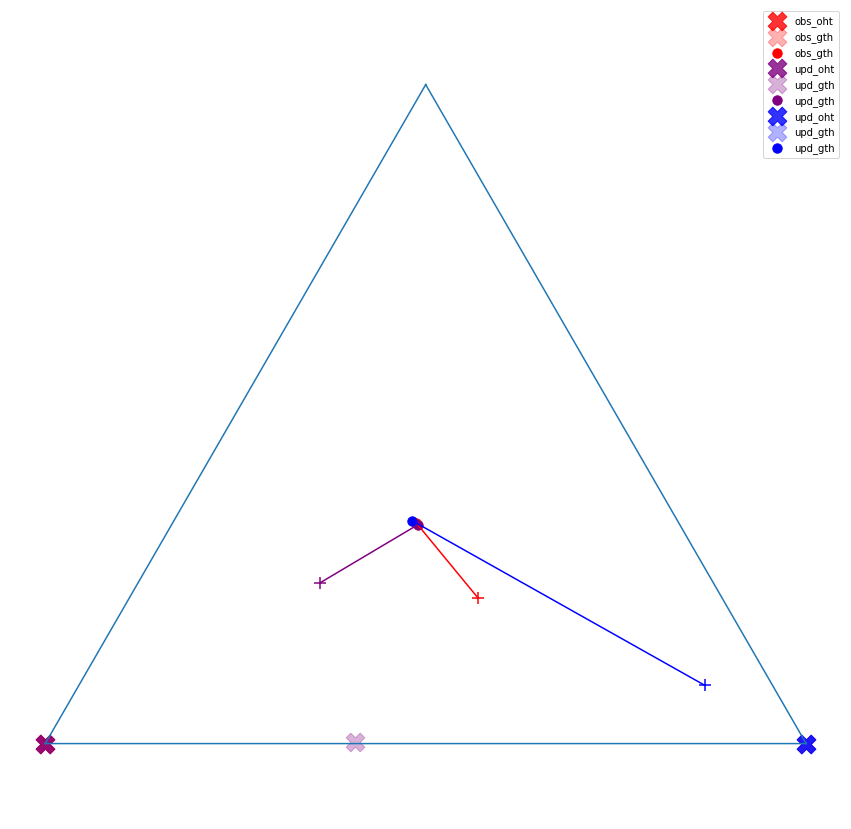

In [ ]:
figure, ax = plt.subplots(1,1,figsize=(15,15))
ax.triplot(triangle)
ax.axis('off')
ax.axis('equal')

ax.scatter(y_star_obs[0],y_star_obs[1],color='red',label='obs_oht',s=350,alpha=0.8,marker='X')
ax.scatter(p_star_obs[0],p_star_obs[1],color='red',label='obs_gth',s=350,alpha=0.3,marker='X')
ax.scatter(q_orig_obs[0],q_orig_obs[1],color='red',label='obs_gth',s=350,alpha=1,marker='.')
ax.scatter(q_orig_obs2[0],q_orig_obs2[1],color='red',s=150,alpha=1,marker='+')
ax.plot([q_orig_obs[0],q_orig_obs2[0]],[q_orig_obs[1],q_orig_obs2[1]],color='red')


ax.scatter(y_star_updA[0],y_star_updA[1],color='purple',label='upd_oht',s=350,alpha=0.8,marker='X')
ax.scatter(p_star_updA[0],p_star_updA[1],color='purple',label='upd_gth',s=350,alpha=0.3,marker='X')
ax.scatter(q_orig_updA[0],q_orig_updA[1],color='purple',label='upd_gth',s=350,alpha=1,marker='.')
ax.scatter(q_orig_upd2A[0],q_orig_upd2A[1],color='purple',s=150,alpha=1,marker='+')
ax.plot([q_orig_updA[0],q_orig_upd2A[0]],[q_orig_updA[1],q_orig_upd2A[1]],color='purple')

ax.scatter(y_star_updB[0],y_star_updB[1],color='blue',label='upd_oht',s=350,alpha=0.8,marker='X')
ax.scatter(p_star_updB[0],p_star_updB[1],color='blue',label='upd_gth',s=350,alpha=0.3,marker='X')
ax.scatter(q_orig_updB[0],q_orig_updB[1],color='blue',label='upd_gth',s=350,alpha=1,marker='.')
ax.scatter(q_orig_upd2B[0],q_orig_upd2B[1],color='blue',s=150,alpha=1,marker='+')
ax.plot([q_orig_updB[0],q_orig_upd2B[0]],[q_orig_updB[1],q_orig_upd2B[1]],color='blue')
ax.legend()
